In [35]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})


In [36]:
### calculate a given mape for a daily df

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

# functions

def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function
    actual = pd.Series(actual)
    forecast = pd.Series(forecast)

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    print(ft_wmape_forecast)
    # return a float
    return "WMAPE",ft_wmape_forecast

def mean_absolute_percentage_error(y_true, y_pred):
    return "MAPE", np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return "MAE",mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    rms = mean_squared_error(y_true, y_pred, squared=False)
    return "RMSE", rms

def mse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=True)
    return "MSE", mse

def medae(y_true, y_pred):
    return "MEDAE", median_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return "R2",r2_score(y_true, y_pred)

def msle(y_true, y_pred):
    return "MSLE", mean_squared_log_error(y_true, y_pred)

def maape(y_true,y_pred): # https://www.sciencedirect.com/science/article/pii/S0169207016000121
    EPSILON = 1e-10
    return "MAAPE", np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))

### from peak challenge
def get_peak_values_from_loadpatterm(loadpattern):
  peakvalues = []
  for i in range (int(len(loadpattern)/24)):
    to_consider = loadpattern[i*24:(i+1)*24]
    peakvalues.append(np.max(to_consider))
  return np.array(peakvalues)

def get_peak_times_from_loadpattern(loadpattern):
    peaktimes = []
    for i in range (int(len(loadpattern)/24)):
        to_consider = loadpattern[i*24:(i+1)*24]
        peaktimes.append(to_consider.tolist().index(np.max(to_consider)))
    to_return = np.array(peaktimes)
    to_return = to_return+1
    return to_return


def shape_score (actual_loadpattern,predicted_loadpattern):
    normed_peaksurroundings_actual = []
    normed_peaksurroundings_pred = []
    for block_index in range (int(len(actual_loadpattern)/24)):
        startindex= block_index*24
        block_actual = actual_loadpattern[startindex:(block_index+1)*24]
        peakvalue_actual = np.max(block_actual)
        peakindex_actual  = np.where(block_actual == peakvalue_actual)[0][0]
        normed_actual = actual_loadpattern/peakvalue_actual

        block_pred = predicted_loadpattern[startindex:(block_index+1)*24]
        peakvalue_pred = np.max(block_pred)
        normed_pred = predicted_loadpattern/peakvalue_pred


        normed_peaksurroundings_actual.extend(normed_actual[startindex + peakindex_actual-2:startindex +peakindex_actual+3])
        normed_peaksurroundings_pred.extend(normed_pred[startindex+peakindex_actual-2: startindex+ peakindex_actual+3])
    normed_peaksurroundings_actual = np.array(normed_peaksurroundings_actual)
    normed_peaksurroundings_pred = np.array(normed_peaksurroundings_pred)
    absolute_errors = abs(normed_peaksurroundings_actual-normed_peaksurroundings_pred)
    return "shape_score", np.sum(absolute_errors)

def peaktime_score(actual_peaktimes, predicted_peaktimes):
    absolute_diffs = abs(actual_peaktimes-predicted_peaktimes)
    total_diffs = 0
    for diff in absolute_diffs:
        if abs(diff)<2:
            total_diffs = total_diffs+diff
        elif abs(diff)<5:
            total_diffs = total_diffs+(diff*2)
        else:
            total_diffs = total_diffs+(10)
    return "peaktime_score", total_diffs


def peak_mape(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_mape", mean_absolute_percentage_error(peakvalues_actual,predictions_at_peaktime)[1]

def peak_rmse(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_rmse", rmse(peakvalues_actual,predictions_at_peaktime)[1]


def peaktime_mae(actual_values, forecasted_values):
  peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
  predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
  return "peaktime_mae", mean_absolute_error(peaktimes_actual,predictions_peaktime)

def percentage_match(peaktimes_actual, predictions_peaktime):
    if len(peaktimes_actual) != len(predictions_peaktime):
        raise ValueError("Arrays must have the same length")

    count_matching = sum(1 for x, y in zip(peaktimes_actual, predictions_peaktime) if x == y)
    total_elements = len(peaktimes_actual)

    percentage = (count_matching / total_elements) * 100
    return percentage

def peaktime_accuracy(actual_values, forecasted_values):
    peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
    predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
    result = percentage_match(peaktimes_actual, predictions_peaktime)

    return "peaktime_accuracy", result

# we also evaluate the metrics for the highest n-decile of true value
def highest_decile_metric(y_true,y_pred,function,decile):
    desired_hits = int(len(y_true)*decile)
    ind_highest = np.argpartition(y_true, -desired_hits)[-desired_hits:]
    top_hits_true = y_true[ind_highest]
    top_hits_pred = y_pred[ind_highest]
    name, res = function(top_hits_true,top_hits_pred)
    return name+"_decile_"+str(decile), res

# evaluation

functions = [mean_absolute_percentage_error,mae,rmse,r2,peak_rmse,peaktime_mae,peaktime_accuracy]

def evaluate_metrics(target_df, functions):
    results = {}
    for function in functions:
        name, res = function(target_df["Agg Load"].values, target_df["Predict"].values)
        results.update({name:res})

    return results

## Individual Aggregated vs. directly combined

In [37]:
#methods = ["LSTM","LSTM CEEMDAM"]
methods = ["XGB", "LSTM","Transformer"]
nn_methods = ["LSTMMSE","LSTM","LSTM CEEMDAN","Transformer"]

hh_results = pd.DataFrame()
hp_results = pd.DataFrame()
total_results = pd.DataFrame()

hh_comparison = pd.DataFrame()
hp_comparison = pd.DataFrame()
total_comparison = pd.DataFrame()

for method in methods:
    print(method)
    comb = pd.DataFrame()
    hp_df = pd.read_pickle("./results/HP "+method+" Results.pkl")
    hh_df = pd.read_pickle("./results/HH "+method+" Results.pkl")
    comb_df = pd.read_pickle("./results/Comb "+method+" Results.pkl")
    if method in nn_methods:
        hp_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        hh_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        comb_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        
    # creating df for plotting
    hh_comparison.index = hh_df.index
    hp_comparison.index = hp_df.index
    total_comparison.index = comb_df.index
    hh_comparison[method] = hh_df["Predict"].values
    hp_comparison[method] = hp_df["Predict"].values
    total_comparison[method] = comb_df["Predict"].values
    hh_comparison["Real Load"] = hh_df["Agg Load"].values
    hp_comparison["Real Load"] = hp_df["Agg Load"].values
    total_comparison["Real Load"] = comb_df["Agg Load"].values
    
    
    comb.index = hp_df.index
    comb["Predict"] = hp_df["Predict"] + hh_df["Predict"]
    comb["Agg Load"] = hp_df["Agg Load"] + hh_df["Agg Load"]
    
    hp_results[method] = evaluate_metrics(hp_df,functions)
    hh_results[method] = evaluate_metrics(hh_df,functions)
    
    total_results[method+" Individual Aggregated"] =  evaluate_metrics(comb,functions)
    total_results[method+" Directly Combined"] =  evaluate_metrics(comb_df,functions)

    
    
    

XGB
LSTM
Transformer


## Rank the results

In [38]:
total_results_rank = total_results.copy()


# Define which metrics should be ranked in ascending order
ascending_metrics = ['MAPE', 'MAE', 'RMSE', 'peak_rmse', 'peaktime_mae']

# Apply ranking row-wise
for metric in total_results.index:
    ascending = metric in ascending_metrics
    total_results_rank.loc[metric] = total_results.loc[metric].rank(method='min', ascending=ascending)


In [39]:
total_results_rank.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/ranks.tex",float_format="%.0f")
total_results_rank

<ipython-input-39-2d3011dcedd2>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  total_results_rank.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/ranks.tex",float_format="%.0f")


,XGB Individual Aggregated,XGB Directly Combined,LSTM Individual Aggregated,LSTM Directly Combined,Transformer Individual Aggregated,Transformer Directly Combined
MAPE,3.000,4.000,6.000,5.000,1.000,2.000
MAE,3.000,5.000,6.000,4.000,1.000,2.000
RMSE,4.000,5.000,6.000,3.000,1.000,2.000
R2,4.000,5.000,6.000,3.000,1.000,2.000
peak_rmse,4.000,5.000,6.000,3.000,2.000,1.000
peaktime_mae,3.000,5.000,6.000,2.000,1.000,4.000
peaktime_accuracy,5.000,4.000,6.000,3.000,1.000,2.000


<AxesSubplot: ylabel='Average rank'>

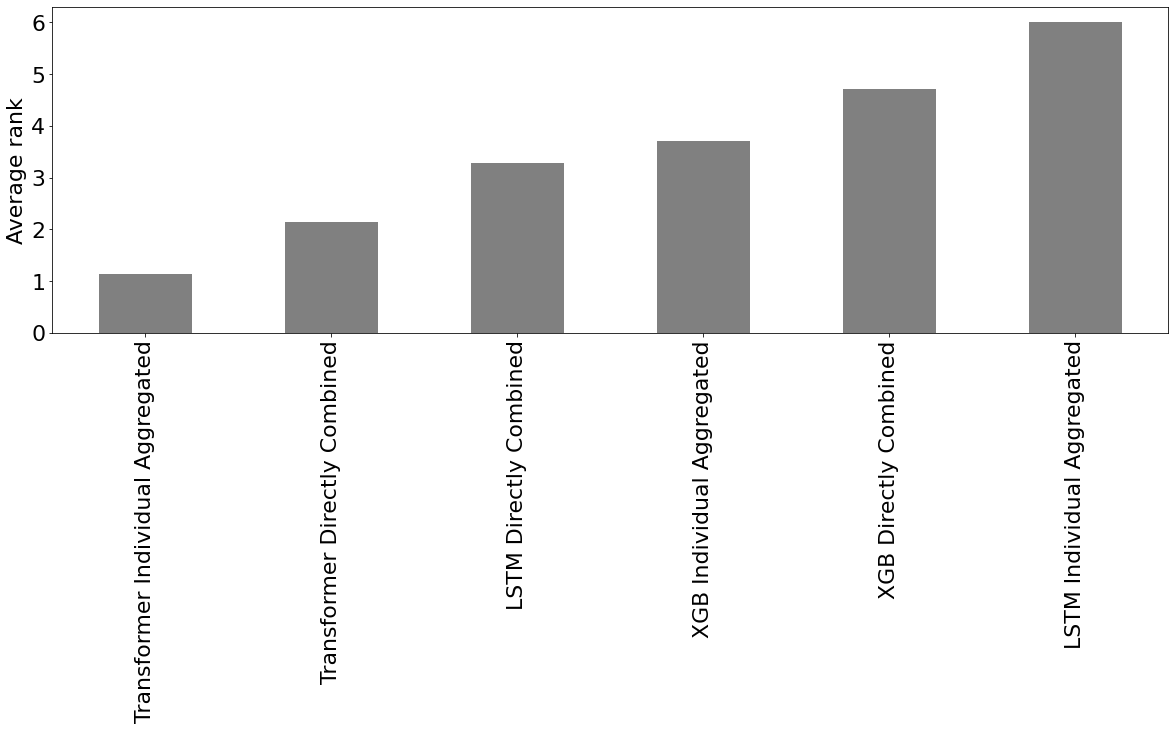

In [40]:
total_results_rank.mean().sort_values().plot.bar(color="grey",figsize=(20,6),ylabel="Average rank")

<AxesSubplot: xlabel='date'>

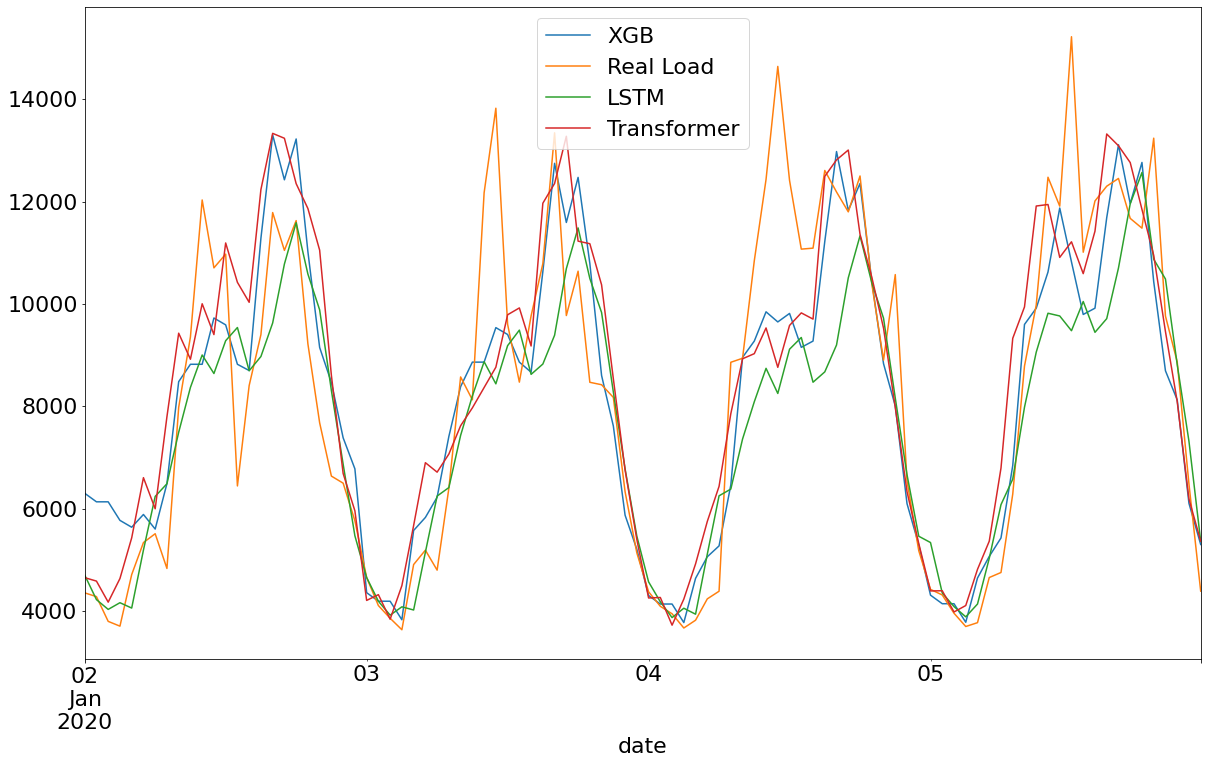

In [41]:
hh_comparison.iloc[24:24*5].plot(figsize=(20,12))

<AxesSubplot: xlabel='date'>

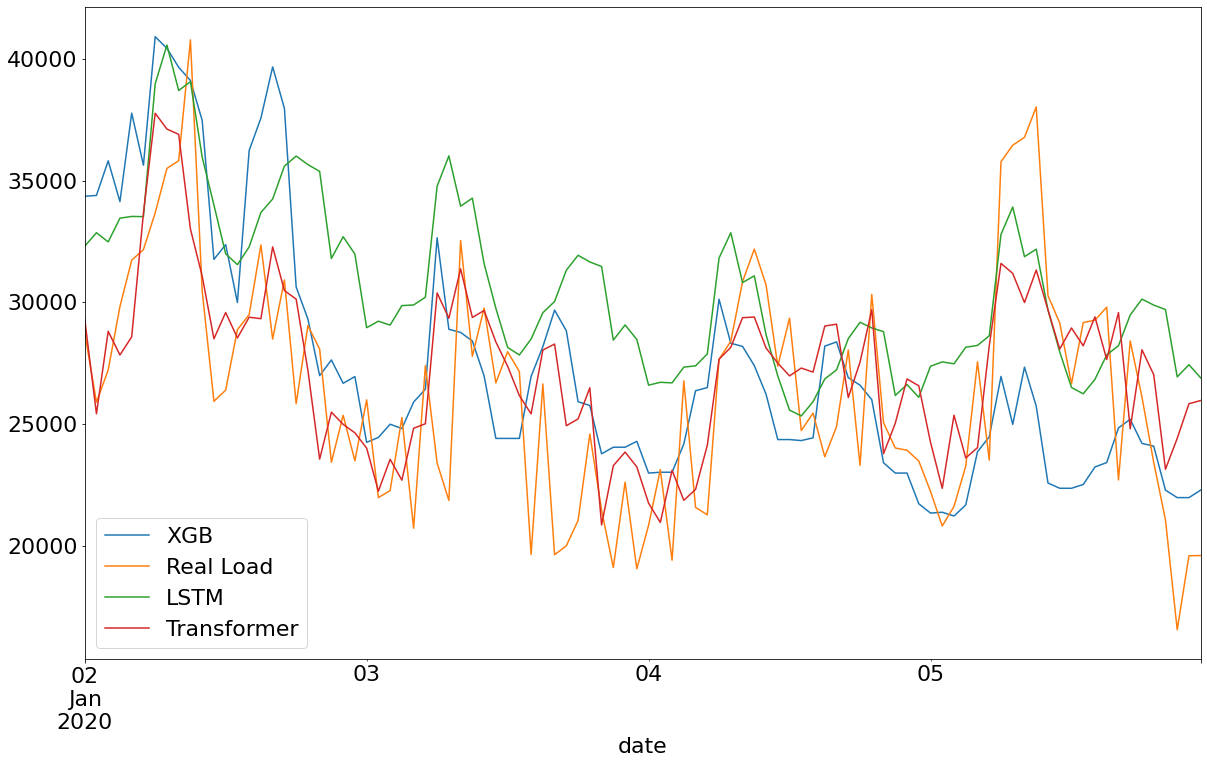

In [42]:
hp_comparison.iloc[24:24*5].plot(figsize=(20,12))

<AxesSubplot: xlabel='date'>

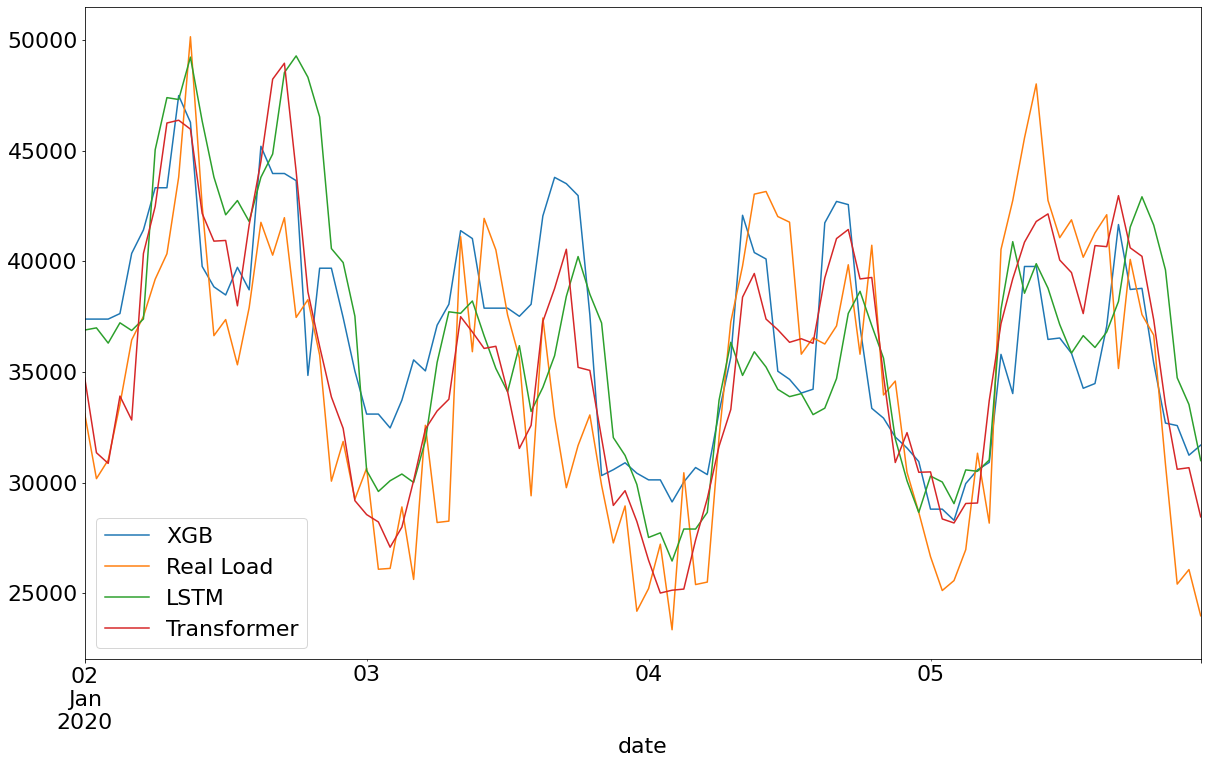

In [43]:
total_comparison.iloc[24:24*5].plot(figsize=(20,12))

In [44]:
hh_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hh_results.tex",float_format="%.1f")
hh_results


<ipython-input-44-0b7bb85a4bfd>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  hh_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hh_results.tex",float_format="%.1f")


,XGB,LSTM,Transformer
MAPE,13.113,14.081,13.779
MAE,969.786,1041.633,1012.168
RMSE,1362.025,1447.215,1414.240
R2,0.738,0.704,0.717
peak_rmse,2327.180,2472.168,2093.418
peaktime_mae,3.235,3.762,3.060
peaktime_accuracy,21.038,13.115,19.126


<AxesSubplot: title={'center': 'MAE'}>

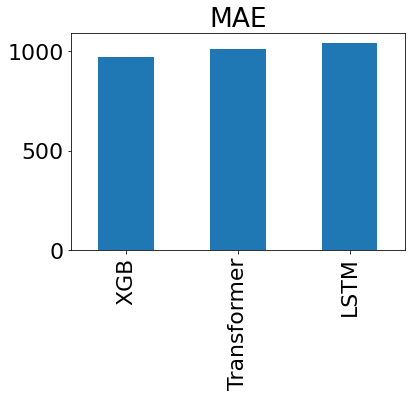

In [45]:
hh_results.T["MAE"].sort_values().plot.bar(title="MAE")

<AxesSubplot: title={'center': 'Peaktime MAE'}>

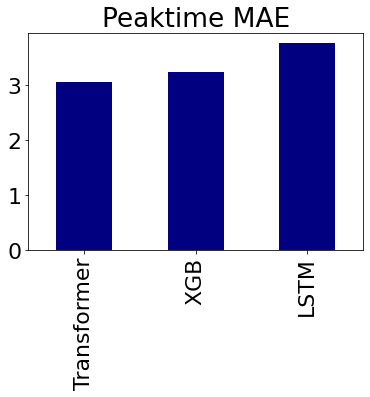

In [46]:
hh_results.T["peaktime_mae"].sort_values().plot.bar(title="Peaktime MAE",color="navy")

In [47]:
hp_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hp_results.tex",float_format="%.1f")

hp_results

<ipython-input-47-7789af18a6a1>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  hp_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/hp_results.tex",float_format="%.1f")


,XGB,LSTM,Transformer
MAPE,49.166,70.505,43.593
MAE,2064.439,2240.222,1780.942
RMSE,2817.449,2908.374,2403.358
R2,0.877,0.869,0.910
peak_rmse,3308.164,3311.188,2726.822
peaktime_mae,4.951,4.443,4.344
peaktime_accuracy,15.847,19.126,15.574


<AxesSubplot: title={'center': 'MAE'}>

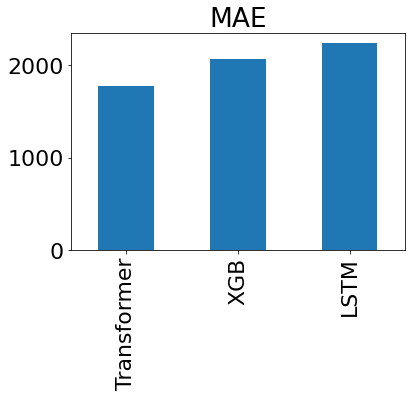

In [48]:
hp_results.T["MAE"].sort_values().plot.bar(title="MAE")

<AxesSubplot: title={'center': 'Peaktime MAE'}>

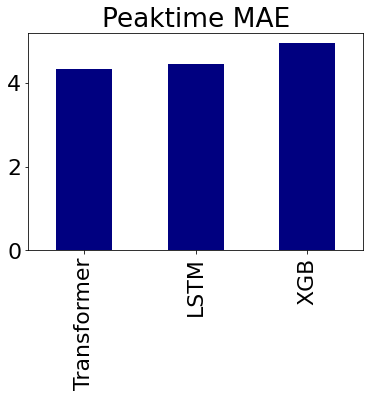

In [49]:
hp_results.T["peaktime_mae"].sort_values().plot.bar(title="Peaktime MAE",color="navy")

In [50]:
total_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/total_results.tex",float_format="%.1f")
total_results.T

<ipython-input-50-2550d0eeaf53>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  total_results.rename({"peak_rmse":"RMSE_P","peaktime_mae":"MAE_P","peaktime_accuracy":"Accuracy"}).T.to_latex("./results/total_results.tex",float_format="%.1f")


,MAPE,MAE,RMSE,R2,peak_rmse,peaktime_mae,peaktime_accuracy
XGB Individual Aggregated,16.477,2375.881,3168.893,0.871,3640.041,4.656,11.475
XGB Directly Combined,16.579,2432.934,3256.328,0.864,3860.070,4.923,13.115
LSTM Individual Aggregated,18.764,2525.473,3265.964,0.863,3899.906,6.046,10.383
LSTM Directly Combined,17.386,2409.674,3117.768,0.875,3481.872,4.418,14.208
Transformer Individual Aggregated,14.734,2128.144,2822.500,0.898,3211.375,3.831,17.760
Transformer Directly Combined,15.596,2198.400,2873.562,0.894,3049.180,4.719,15.574


<AxesSubplot: title={'center': 'MAE'}>

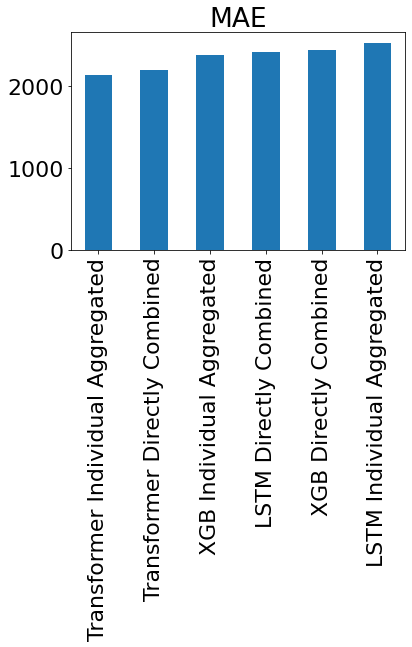

In [51]:
total_results.T["MAE"].sort_values().plot.bar(title="MAE")

<AxesSubplot: title={'center': 'Peaktime MAE'}>

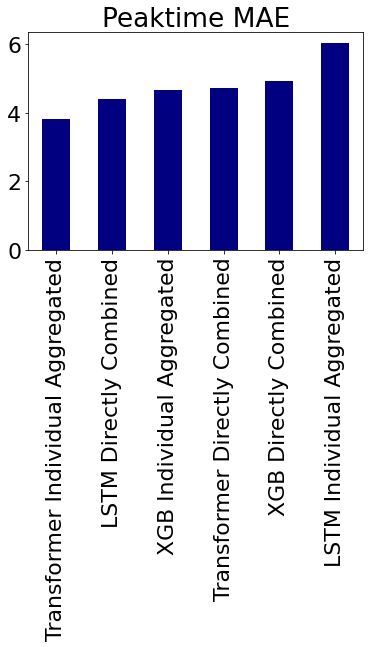

In [52]:
total_results.T["peaktime_mae"].sort_values().plot.bar(title="Peaktime MAE",color="navy")

## Monthly RMSE performance

In [54]:
hp_monthly_results = pd.DataFrame()
hh_monthly_results = pd.DataFrame()


for method in methods:
    print(method)
    comb = pd.DataFrame()
    hp_df = pd.read_pickle("./results/HP "+method+" Results.pkl")
    hh_df = pd.read_pickle("./results/HH "+method+" Results.pkl")
    comb_df = pd.read_pickle("./results/Comb "+method+" Results.pkl")
    if method in nn_methods:
        hp_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        hh_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        comb_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
    
    hp_df["RMSE"] = hp_df.apply(lambda x: rmse([x["Agg Load"]], [x["Predict"]])[1],axis=1)
    grouped_df = hp_df.groupby(hp_df.index.month).mean()
    hp_monthly_results.index = grouped_df.index
    hp_monthly_results[method] = grouped_df["RMSE"]
    
    hh_df["RMSE"] = hh_df.apply(lambda x: rmse([x["Agg Load"]], [x["Predict"]])[1],axis=1)
    grouped_df = hh_df.groupby(hh_df.index.month).mean()
    hh_monthly_results.index = grouped_df.index
    hh_monthly_results[method] = grouped_df["RMSE"]

XGB
LSTM
Transformer


<AxesSubplot: xlabel='date'>

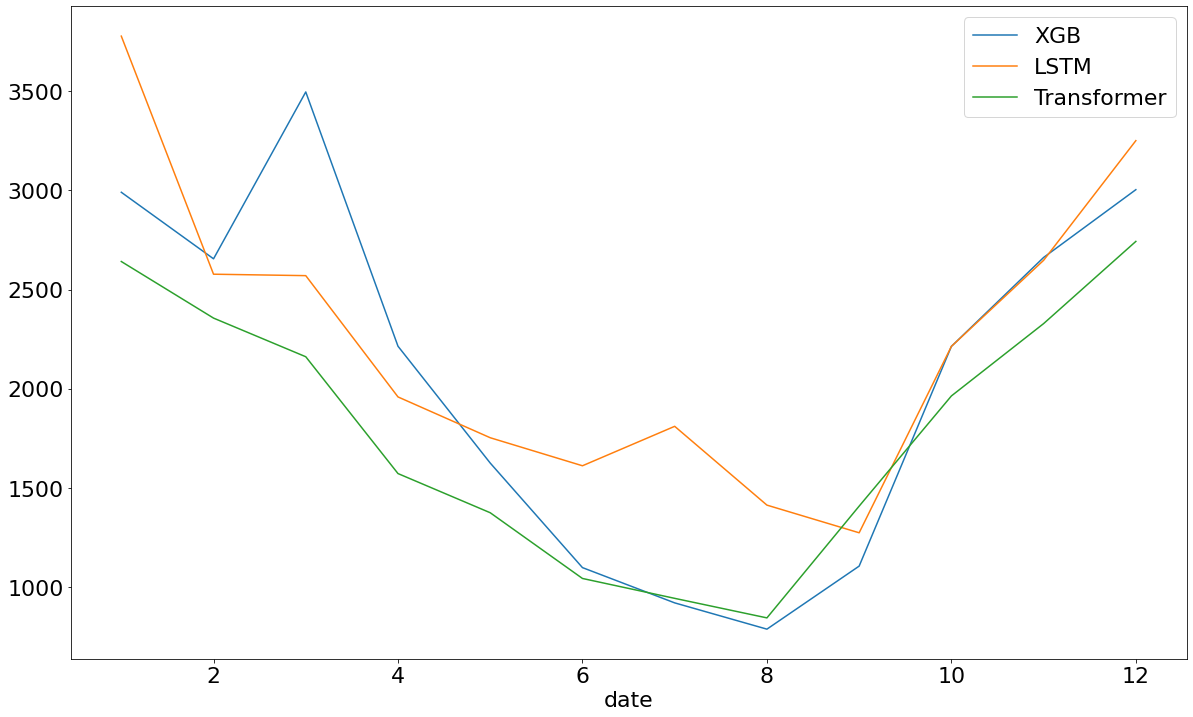

In [55]:
hp_monthly_results.plot(figsize=(20,12))

<AxesSubplot: xlabel='date'>

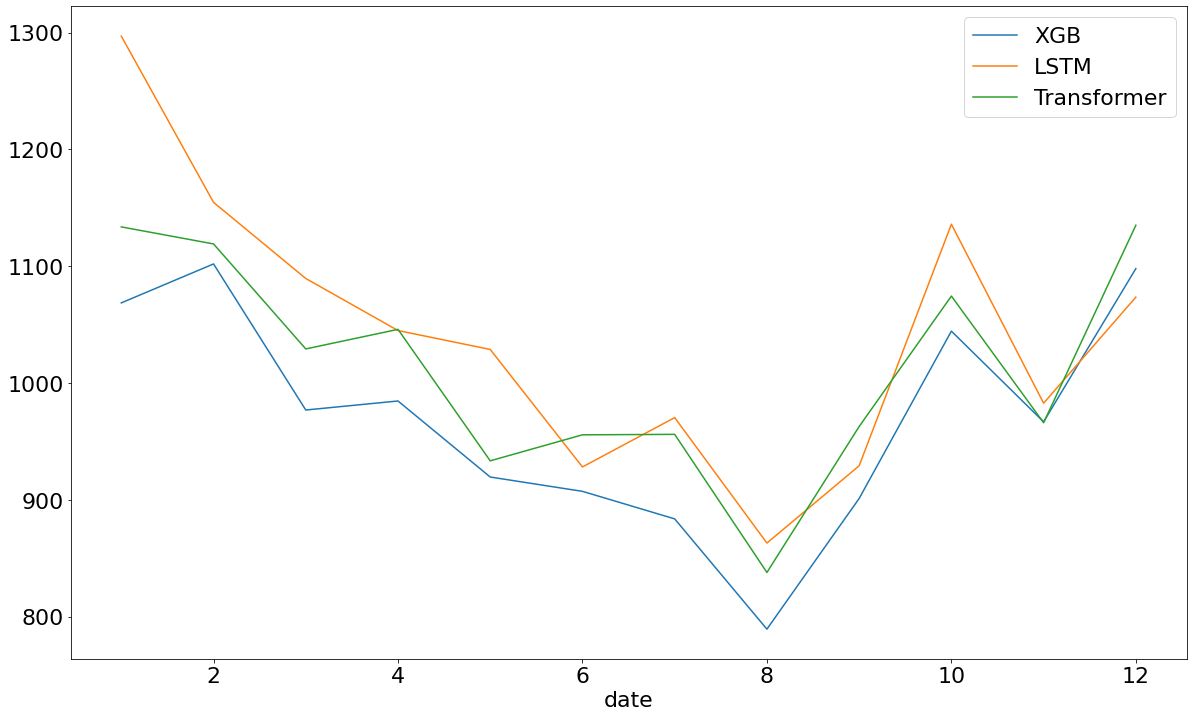

In [56]:
hh_monthly_results.plot(figsize=(20,12))